### 데이터 증식, 전이 학습을 이용한 이미지 분류 모델

In [5]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
#import matplotlib.image as mpimg
from PIL import Image
import os
import matplotlib.pyplot as plt

In [2]:
# ImageDataGenerator() 함수와 flow_from_directory() 함수를 사용하여 학습 데이터를 증식시키기 

HEIGHT = 224
WIDTH = 224

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# setting the path of datasets
train_dir = os.getcwd()+"/img/train"
val_dir = os.getcwd()+"/img/val"

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(HEIGHT, WIDTH),
                                                    shuffle=True,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                batch_size=16, 
                                                target_size=(HEIGHT, WIDTH),
                                                shuffle=True,
                                                class_mode='categorical')

Found 4061 images belonging to 11 classes.
Found 880 images belonging to 11 classes.


In [3]:
# 사전 학습된 모델 불러와서 기본 모델 생성하기

base_model = InceptionResNetV2(weights='imagenet',
                               include_top = False,
                               input_shape=(224,224,3))

In [4]:
# 기본 모델 구조 확인하기

print(base_model.summary())

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [5]:
# trainable = False를 이용하여 기본 모델의 전 계층 동결하기

for layer in base_model.layers:
    layer.trainable = False

print(base_model.summary())

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [6]:
# 전이 학습 모델 정의 하기

classes = 11

def create_model():
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu',  kernel_initializer='he_normal', bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='softmax'))
    
    print(model.summary())    
    
    return model

In [7]:
model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
batch_normalization_204 (Bat (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1000
127/127 [==============================] - 216s 2s/step - loss: 2.3671 - accuracy: 0.3546 - val_loss: 1.0050 - val_accuracy: 0.6807
Epoch 2/1000
127/127 [==============================] - 251s 2s/step - loss: 1.6287 - accuracy: 0.5376 - val_loss: 0.8100 - val_accuracy: 0.7398
Epoch 3/1000
127/127 [==============================] - 260s 2s/step - loss: 1.4055 - accuracy: 0.5979 - val_loss: 0.7559 - val_accuracy: 0.7591
Epoch 4/1000
127/127 [==============================] - 267s 2s/step - loss: 1.3663 - accuracy: 0.6139 - val_loss: 0.7270 - val_accuracy: 0.7682
Epoch 5/1000
127/127 [==============================] - 273s 2s/step - loss: 1.2879 - accuracy: 0.6292 - val_loss: 0.7080 - val_accuracy: 0.7761
Epoch 6/1000
127/127 [==============================] - 294s 2s/step - loss: 1.2236 - accuracy: 0.6427 - val_loss: 0.6743 - val_accuracy: 0.7864
Epoch 7/1000
127/127 [==============================] 

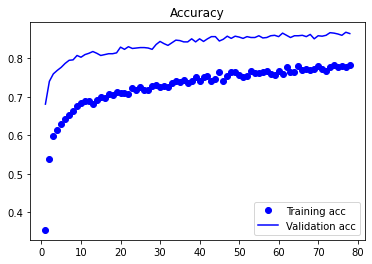

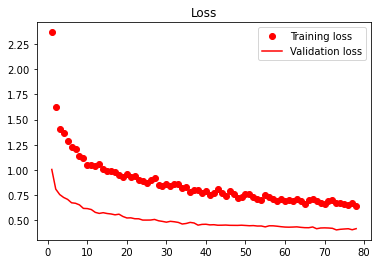

In [8]:
# 학습 결과를 저장할 디렉토리 생성
checkpoint_dir = os.getcwd()+"/model"
os.makedirs(checkpoint_dir, exist_ok=True)

# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
checkpoint = ModelCheckpoint(filepath=checkpoint_dir+"/"+"project_weight.hdf5",
                             monitor='val_loss',
                             mode='auto',
                             save_best_only=True)

# 모델 컴파일
optimizer = Adam(lr=0.0001)
loss = "categorical_crossentropy"

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])


# 헉습 진행
history = model.fit_generator(train_generator,
                              epochs=1000,
                              validation_data=val_generator, 
                              validation_steps=len(val_generator),
                              callbacks=[early_stop, checkpoint])

#visualizing
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [3]:
import os 
print(os.listdir)

<built-in function listdir>


In [6]:
#모델 테스트
HHH = 224
WWW = 224

test_dir = os.getcwd() + '/img/test/'

img_path = []
for i in os.listdir(test_dir):
    test_img_name = test_dir + i
    img_path.append(test_img_name)
    
print(img_path)

for i in img_path:
    img = Image.open(i).convert('RGB')
    img = img.resize((HHH, WWW))
    X = np.array(img)
    X = X.astype('float')/255
    X = X.reshape(-1, HHH, WWW, 3)
    print(type(img))
    #c = ['book', 'cave','dessert','dog','drawing', 'industrial', 'modern', 'nature', 'ocean','retro', 'rooftop']
    path = os.getcwd() + '/img/train'
    categories = os.listdir(path)
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]
    
    print('New image prediction : ',categories[result[0]])
    print("accuracy : {}".format(np.max(pred[0]))) #by 
    plt.axis('off')
    plt.imshow(img)
    plt.show()  

['C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/book (681).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/book (682).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/book (683).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/book (684).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/book (685).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/book (686).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/book (687).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/bread (569).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/bread (570).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/bread (571).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/bread (572).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/bread (573).jpg', 'C:\\Users\\CGI\\Three\\deep_learning_model - (4)/img/test/bread (574).jpg', 'C:\\

NameError: name 'model' is not defined

In [10]:
#모델저장
model.save('model_0731.hdf5')

In [ ]:
#모델 테스트
HHH = 224
WWW = 224

test_dir = os.getcwd()

img_path = []
for i in os.listdir(test_dir):
    test_img_name = test_dir + i
    img_path.append(test_img_name)
    
print(img_path)

for i in img_path:
    img = Image.open(i).convert('RGB')
    img = img.resize((HHH, WWW))
    X = np.array(img)
    X = X.astype('float')/255
    X = X.reshape(-1, HHH, WWW, 3)
    
    #c = ['book', 'cave','dessert','dog','drawing', 'industrial', 'modern', 'nature', 'ocean','retro', 'rooftop']
    path = os.getcwd() + '/img/train'
    categories = os.listdir(path)
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]
    
    print('New image prediction : ',categories[result[0]])
    print("accuracy : {}".format(np.max(pred[0]))) #by 
    plt.axis('off')
    plt.imshow(img)
    plt.show()  